# Setup

In [779]:
import networkx as nx
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import powerlaw

import arrow

from scipy.special import factorial
from math import e

### Load Project Data

In [780]:
projects = [
    'bayc', 
    'coolcats', 
    'cryptoadz', 
    'cyberkongz', 
    'hashmasks', 
    'mayc', 
    'meebits', 
    'mekaverse', 
    'svs'
]

In [781]:
df_summaries = {}

column_names = [
    "date", 
    "days_since_mint", 
    "from_address", 
    "to_address", 
    "token_id", 
    "blk_number", 
    "eth_value", 
    "usd_value", 
    "from_value", 
    "to_value", 
    "from_value_usd", 
    "to_value_usd"
]

for project in projects:
    np_data = np.load(f"./memory/{project}/full.npy", allow_pickle=True)
    df_summaries[project] = pd.DataFrame(data=np_data, columns=column_names).infer_objects()

### Get project price performance

In [782]:
def get_price_performance_series(project):
    df = df_summaries[project]
    df = df[df['eth_value'] != 0]
    
    df_price = df.groupby('days_since_mint').agg({'token_id': 'count', 'usd_value':'sum'}).reset_index().rename(columns={'token_id':'token_count', 'usd_value': 'aggregrate_usd_value'})
    df_price['usd_per_token'] = df_price['aggregrate_usd_value'] / df_price['token_count']
    
    return (df_price['days_since_mint'], df_price['usd_per_token'])

# Aggregrate Measures

### ETH inflows over DSM

In [783]:
def plot_eth_over_dsm(dfs):
    sort = lambda x: x.sort_values(by=['days_since_mint'])
    group = lambda x: x.groupby(by=['days_since_mint']).sum()
    
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('ETH Inflows over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        df = group(sort(dfs[keys[i]]))

        price_x, price_y = get_price_performance_series(keys[i])

        ln1 = ax.plot(df.index, df.eth_value, color='b', label="ETH inflows")
        ax.set_title(keys[i])
        ax.set_yscale("log")
        ax.set_xlabel("days since mint")
        ax.set_ylabel("value inflow (ETH)")

        ax_twin = ax.twinx()
        ln2 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

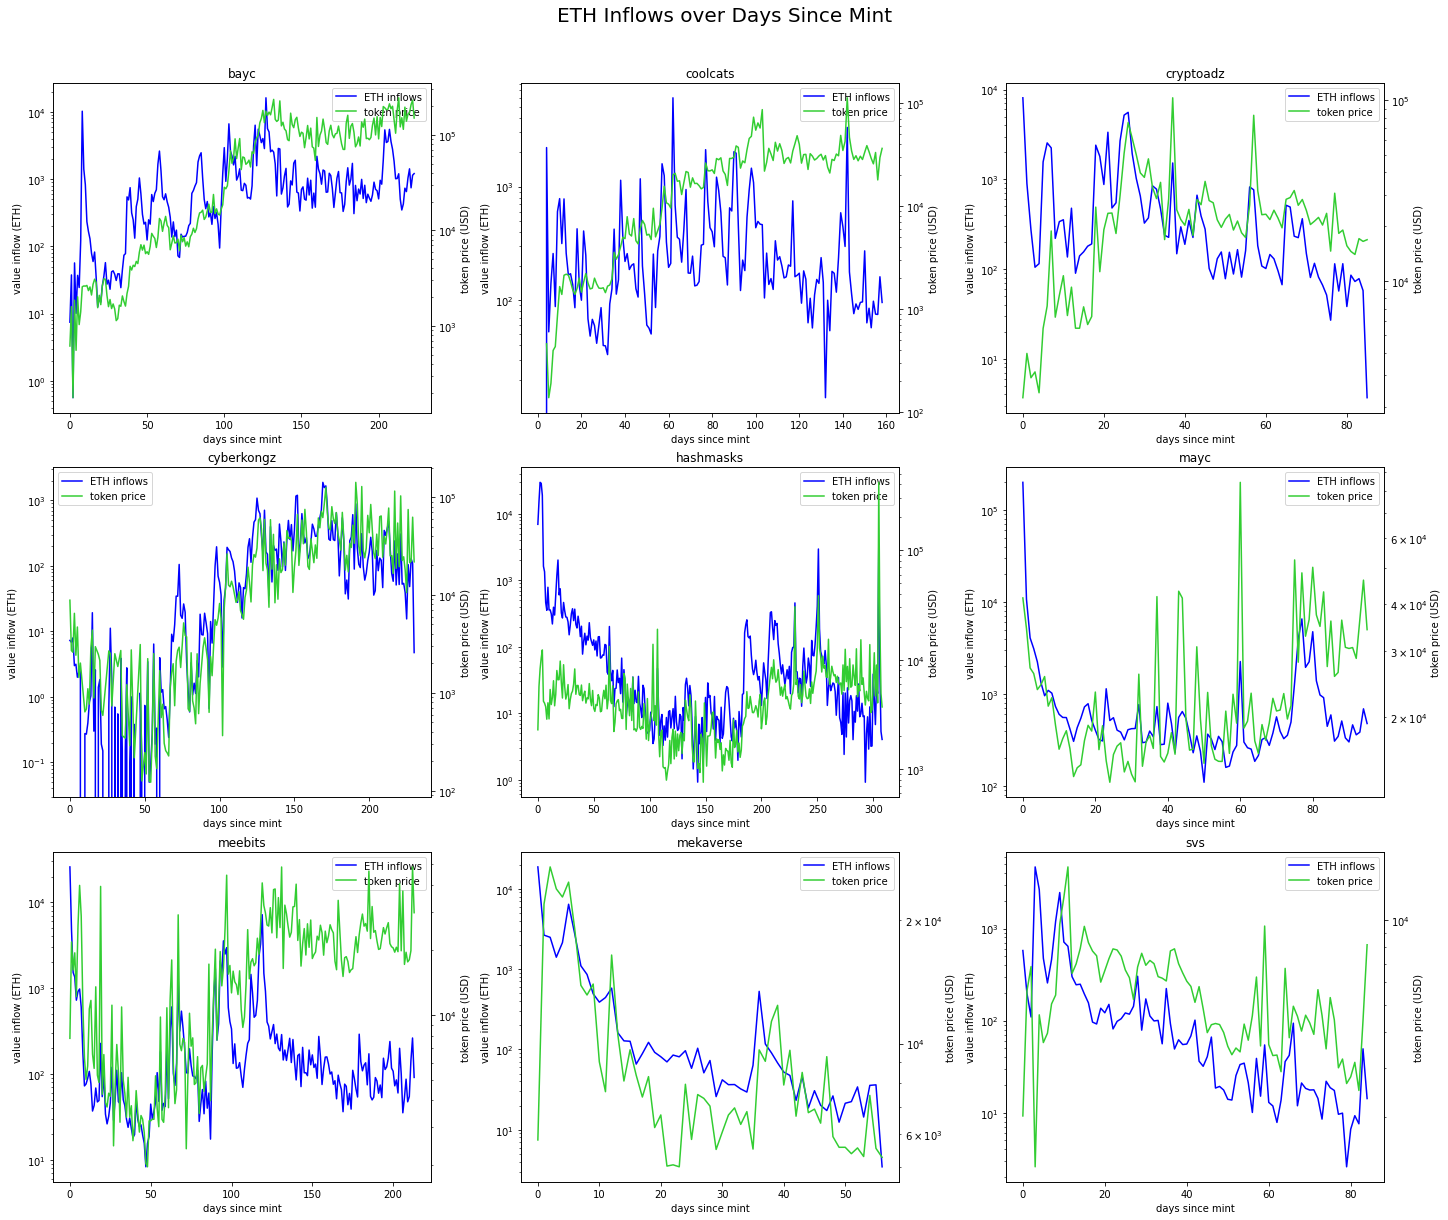

In [784]:
plot_eth_over_dsm(df_summaries)

### Aggregate ETH value over DSM

In [785]:
def get_aggregate_project_value_series(project):
    df = df_summaries[project]
    df_agg = df.groupby('days_since_mint')['eth_value'].sum().reset_index()
    
    x_series = []
    y_series = []
    
    current = 0 
    for i, row in df_agg.iterrows():
        x_series.append(row['days_since_mint'])
        
        current += row['eth_value']
        y_series.append(current)
        
    return (x_series, y_series)

In [786]:
def plot_aggregate_project_value_over_dsm(dfs):
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('Aggregate Project Value over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        agg_x, agg_y = get_aggregate_project_value_series(keys[i])
        price_x, price_y = get_price_performance_series(keys[i])

        ln1 = ax.plot(agg_x, agg_y, color='b', label="aggregate project value")
        ax.set_title(keys[i])
        ax.set_xlabel("days since mint")
        ax.set_ylabel("aggregrate project value (ETH)")

        ax_twin = ax.twinx()
        ln2 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

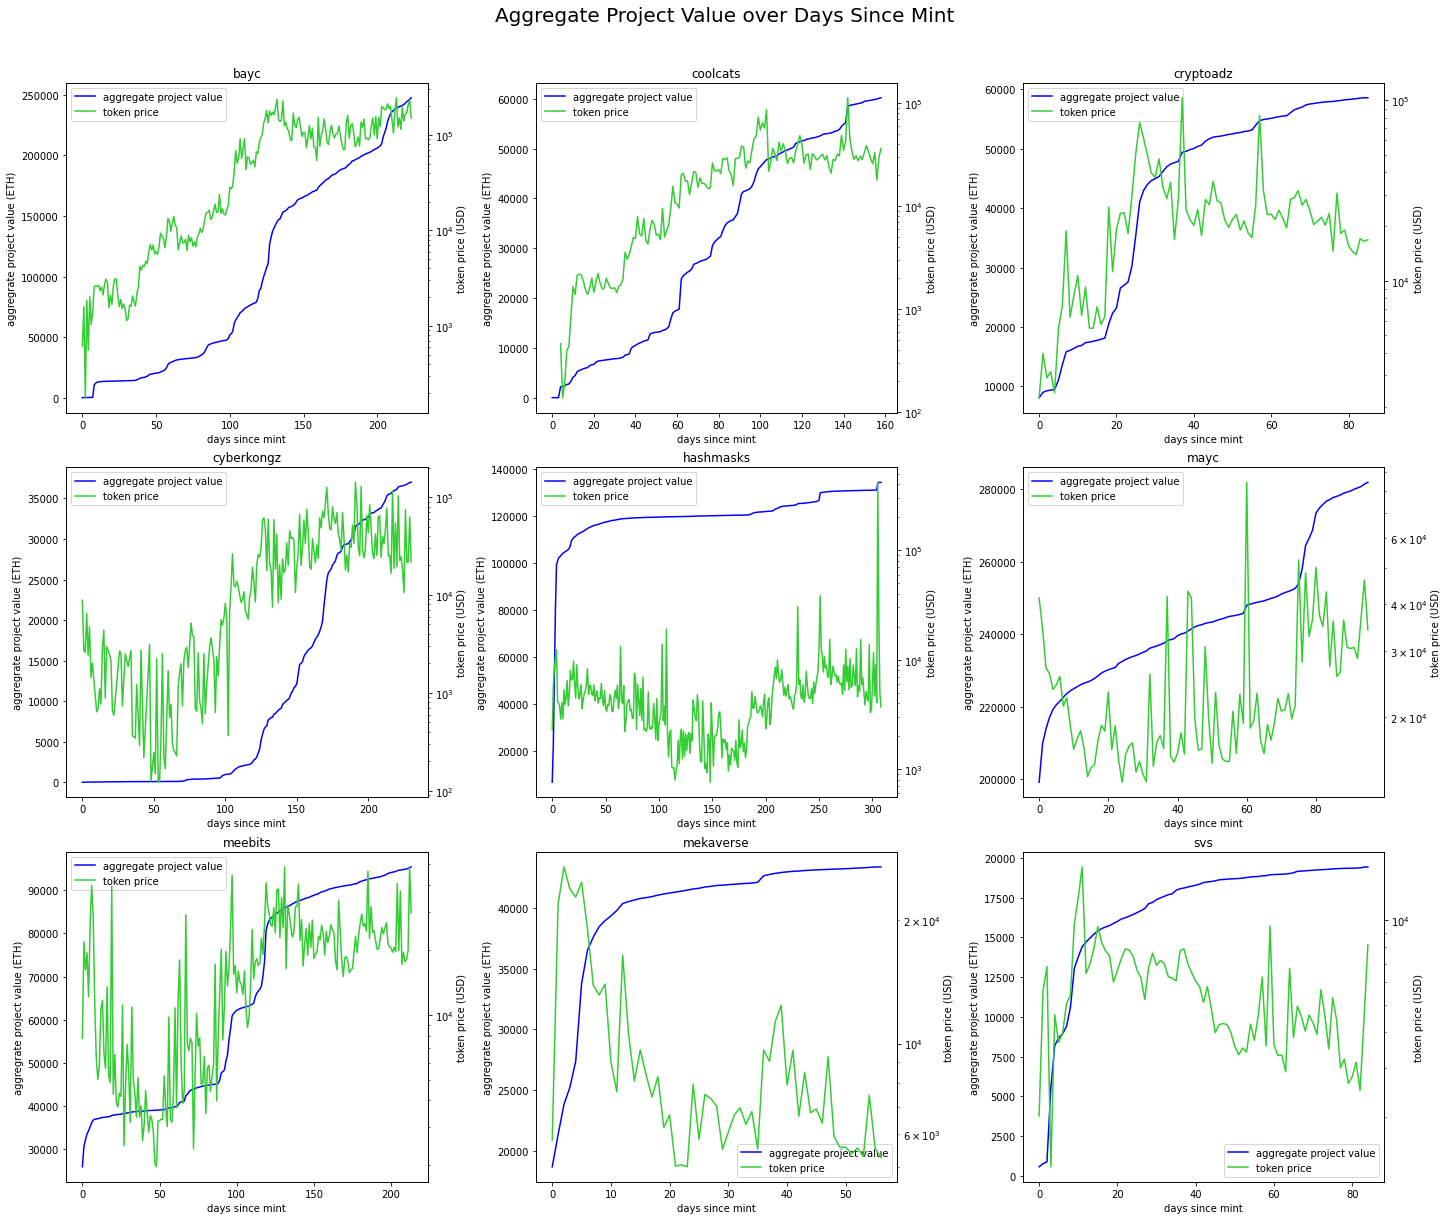

In [787]:
plot_aggregate_project_value_over_dsm(df_summaries)

### USD inflows over DSM

In [788]:
def plot_usd_over_dsm(dfs):
    sort = lambda x: x.sort_values(by=['days_since_mint'])
    group = lambda x: x.groupby(by=['days_since_mint']).sum()
    
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('USD Inflows over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        df = group(sort(dfs[keys[i]]))

        price_x, price_y = get_price_performance_series(keys[i])

        ln1 = ax.plot(df.index, df.usd_value, color='b', label="USD inflows")
        ax.set_title(keys[i])
        ax.set_yscale("log")
        ax.set_xlabel("days since mint")
        ax.set_ylabel("value inflow (USD)")

        ax_twin = ax.twinx()
        ln2 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

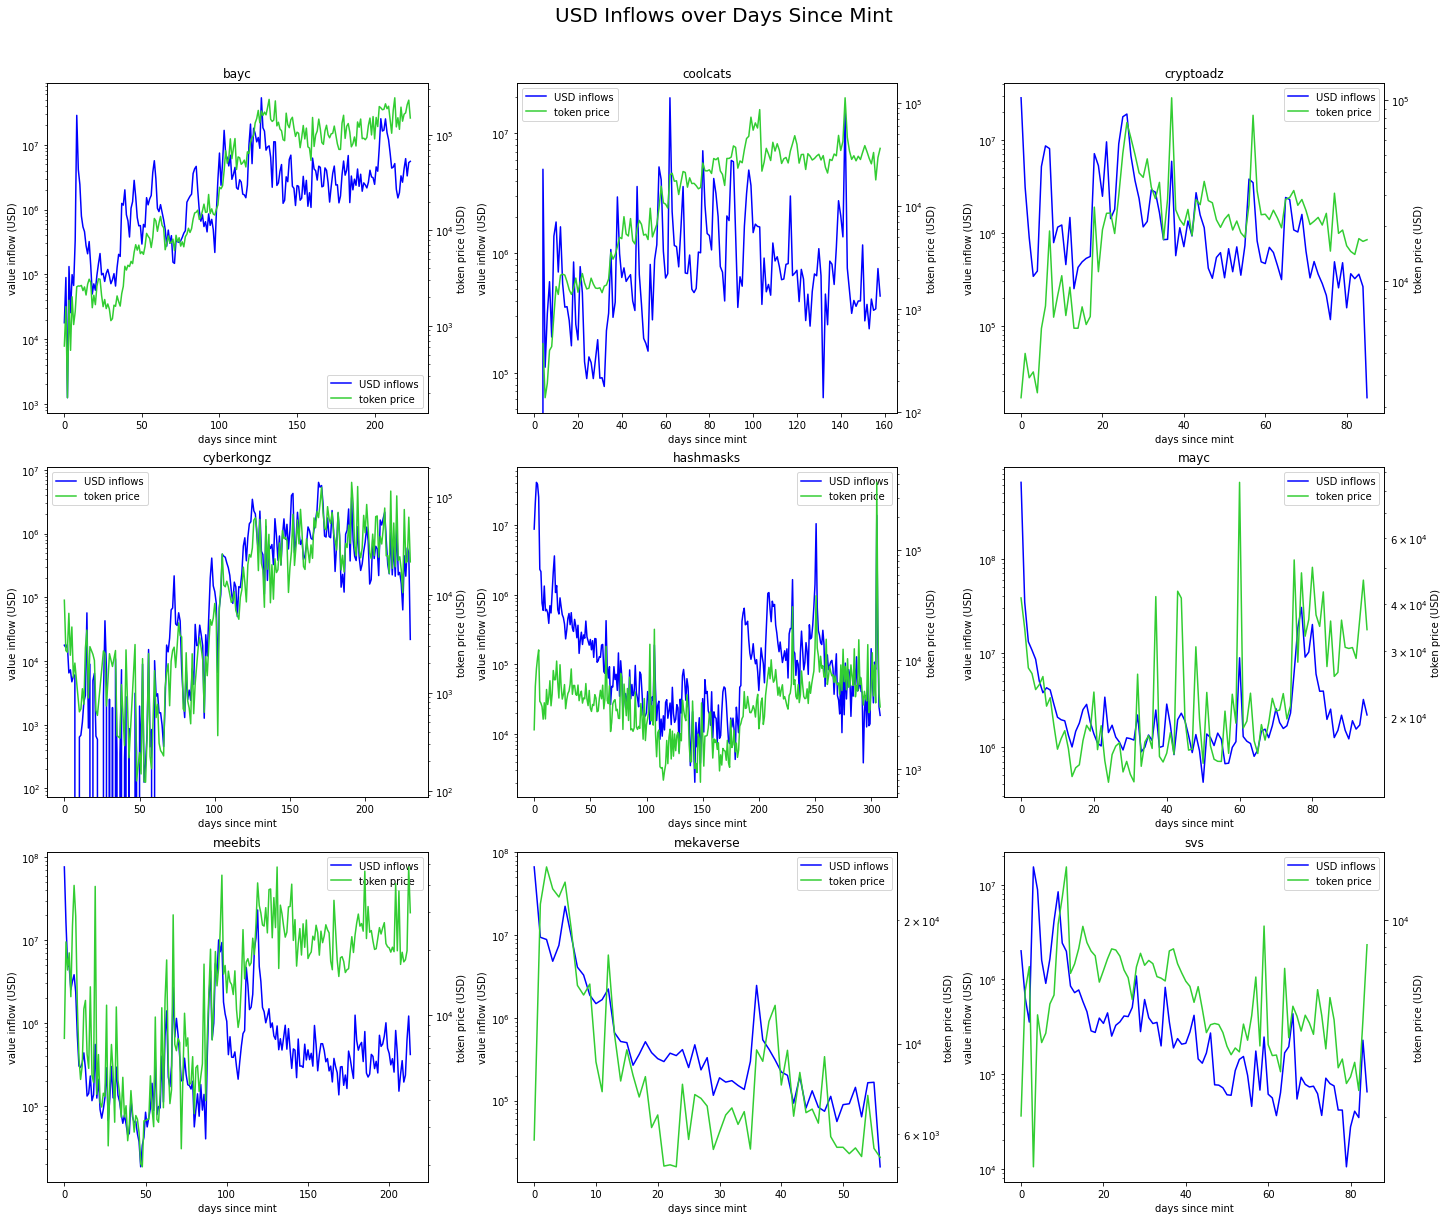

In [789]:
plot_usd_over_dsm(df_summaries)

### Number of transactions over DSM

In [790]:
def plot_transactions_over_dsm(dfs):
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('Transactions over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        df = dfs[keys[i]]

        price_x, price_y = get_price_performance_series(keys[i])

        ax.hist(df.days_since_mint, bins=100, color='b', label="transactions")
        ax.set_title(keys[i])
        ax.set_yscale("log")
        ax.set_xlabel("days since mint")
        ax.set_ylabel("number of transactions")

        ax_twin = ax.twinx()
        ln1 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

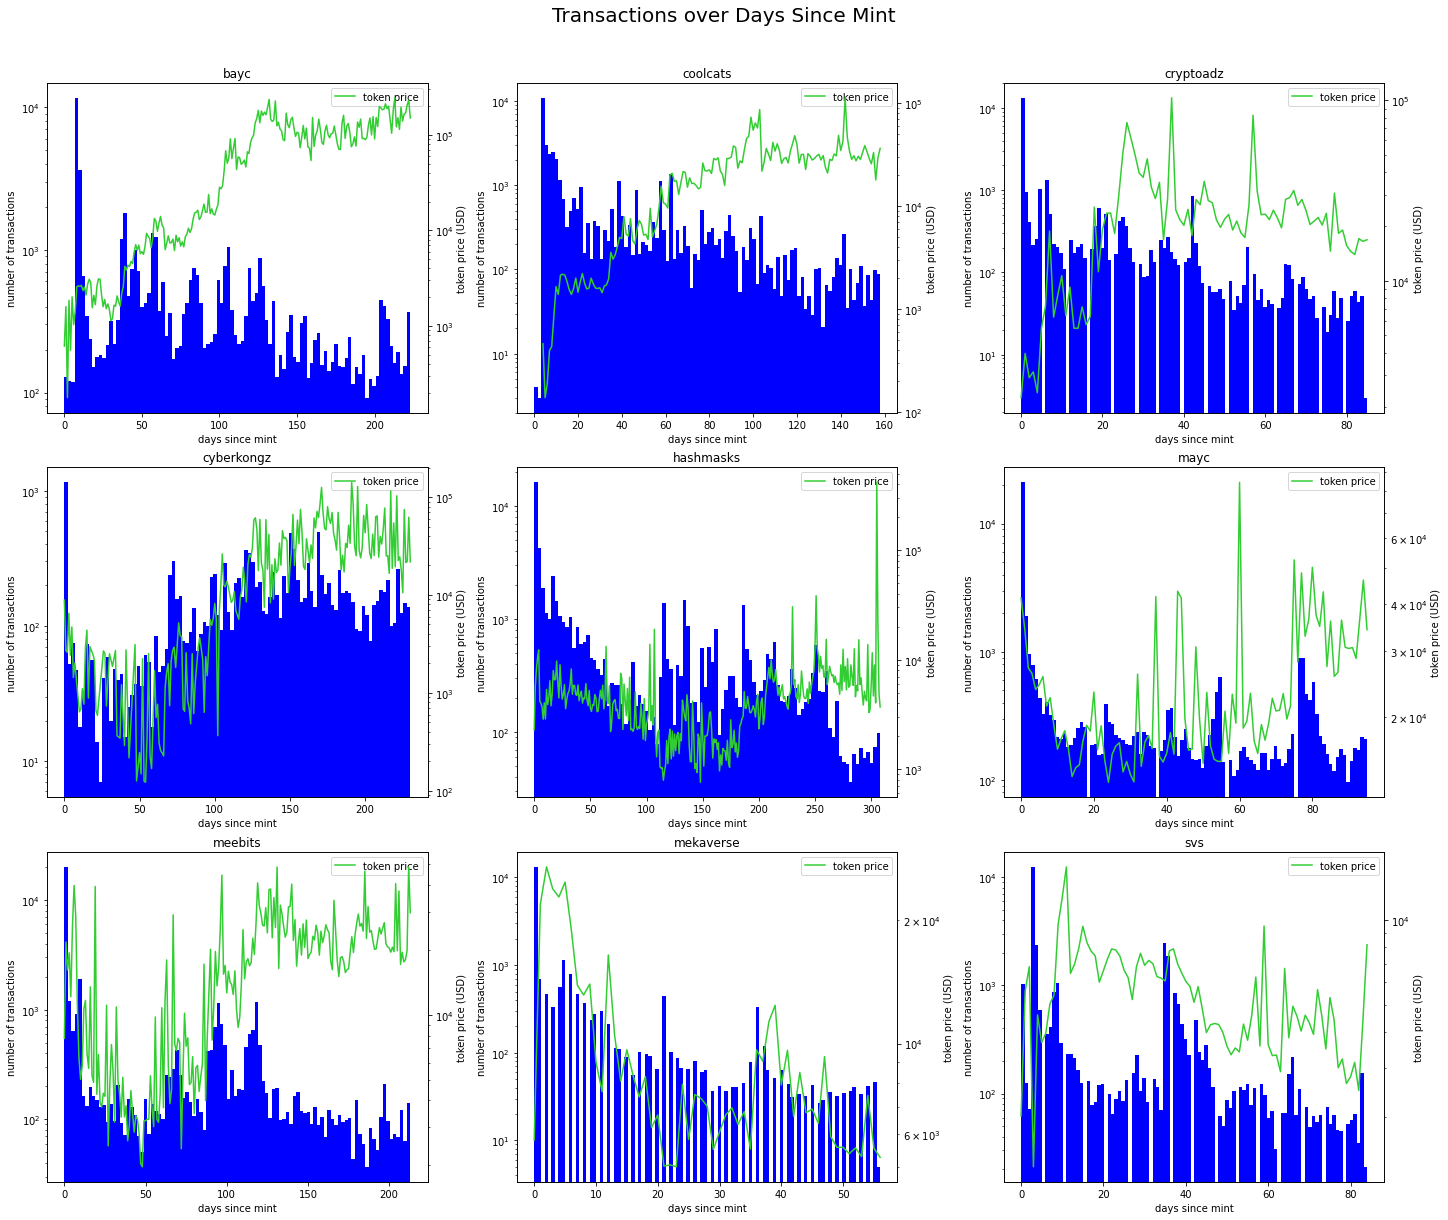

In [791]:
plot_transactions_over_dsm(df_summaries)

### Unique holders over DSM

In [792]:
def get_unique_holders_series(project):
    df = df_summaries[project]
    df_holders = df.groupby('days_since_mint')['from_address', 'to_address']
    
    x_series = []
    y_series = []
    
    uniques = set()
    for name, group in df_holders:
        for i, row in group.iterrows():
            uniques.add(row['from_address'])
            uniques.add(row['to_address'])
        
        x_series.append(name)
        y_series.append(len(uniques))
        
    return (x_series, y_series)

In [793]:
def plot_unique_holders_over_dsm(dfs):
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('Unique Holders over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        unique_x, unique_y = get_unique_holders_series(keys[i])
        price_x, price_y = get_price_performance_series(keys[i])

        ln1 = ax.plot(unique_x, unique_y, color='b', label="unique holders")
        ax.set_title(keys[i])
        ax.set_yscale("log")
        ax.set_xlabel("days since mint")
        ax.set_ylabel("unique holders")

        ax_twin = ax.twinx()
        ln2 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

/var/folders/gk/khvnn6wj7dlftf3q15wdh9hw0000gn/T/ipykernel_5229/1954616037.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_holders = df.groupby('days_since_mint')['from_address', 'to_address']
/var/folders/gk/khvnn6wj7dlftf3q15wdh9hw0000gn/T/ipykernel_5229/1954616037.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_holders = df.groupby('days_since_mint')['from_address', 'to_address']
/var/folders/gk/khvnn6wj7dlftf3q15wdh9hw0000gn/T/ipykernel_5229/1954616037.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_holders = df.groupby('days_since_mint')['from_address', 'to_address']
/var/folders/gk/khvnn6wj7dlftf3q15wdh9hw0000gn/T/ipykernel_5229/1954616037.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple 

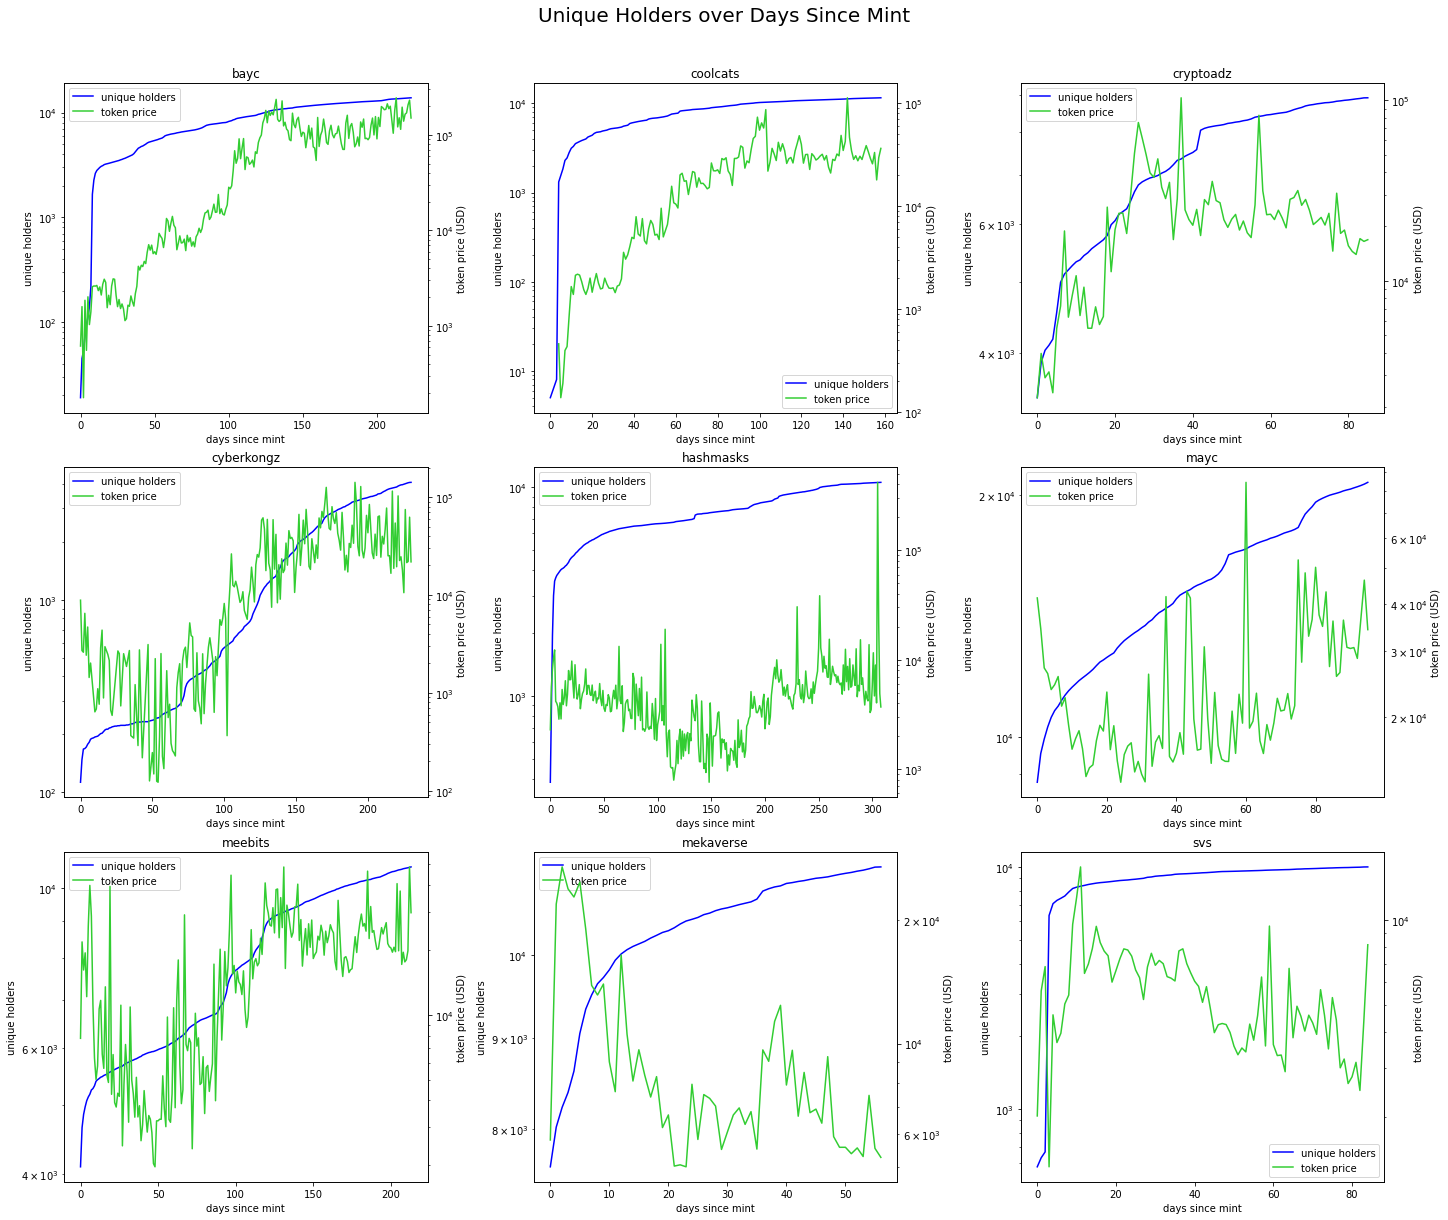

In [794]:
plot_unique_holders_over_dsm(df_summaries)

### Aggregate holder ETH value over DSM (Whale Watching)

In [795]:
def get_aggregate_holder_value_series(project):
    ZERO_ADDRESS = '0x0000000000000000000000000000000000000000'
    
    df = df_summaries[project]
    df_agg = df.groupby('days_since_mint')
    
    x_series = []
    y_series = []
    
    already_seen = set()
    
    # Clever trick - we add the 0x0 address here
    already_seen.add(ZERO_ADDRESS)
    
    current = 0
    for name, group in df_agg:
        for i, row in group.iterrows():
            from_address = row['from_address']
            to_address = row['to_address']
            
            from_value = row['from_value'] if not from_address in already_seen else 0
            to_value = row['to_value'] if not to_address in already_seen else 0
            
            already_seen.add(from_address)
            already_seen.add(to_address)
            
            current += (from_value + to_value)
        
        x_series.append(name)
        y_series.append(current)
        
    return (x_series, y_series)

In [796]:
def plot_aggregate_holder_value_over_dsm(dfs):
    keys = [key for key in dfs.keys()]
    
    fig, axs = plt.subplots(3, 3, figsize=(20, 16), constrained_layout=True)
    fig.suptitle('Aggregate Holder Value over Days Since Mint', y=1.05, fontsize=20)
    
    for i, ax in enumerate(axs.flatten()):
        agg_x, agg_y = get_aggregate_holder_value_series(keys[i])
        price_x, price_y = get_price_performance_series(keys[i])

        ln1 = ax.plot(agg_x, agg_y, color='b', label="aggregate holder value")
        ax.set_title(keys[i])
        ax.set_xlabel("days since mint")
        ax.set_ylabel("aggregrate holder value (ETH)")

        ax_twin = ax.twinx()
        ln2 = ax_twin.plot(price_x, price_y, color='limegreen', label="token price")
        ax_twin.set_yscale("log")
        ax_twin.set_ylabel("token price (USD)")

        lns = ln1 + ln2
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

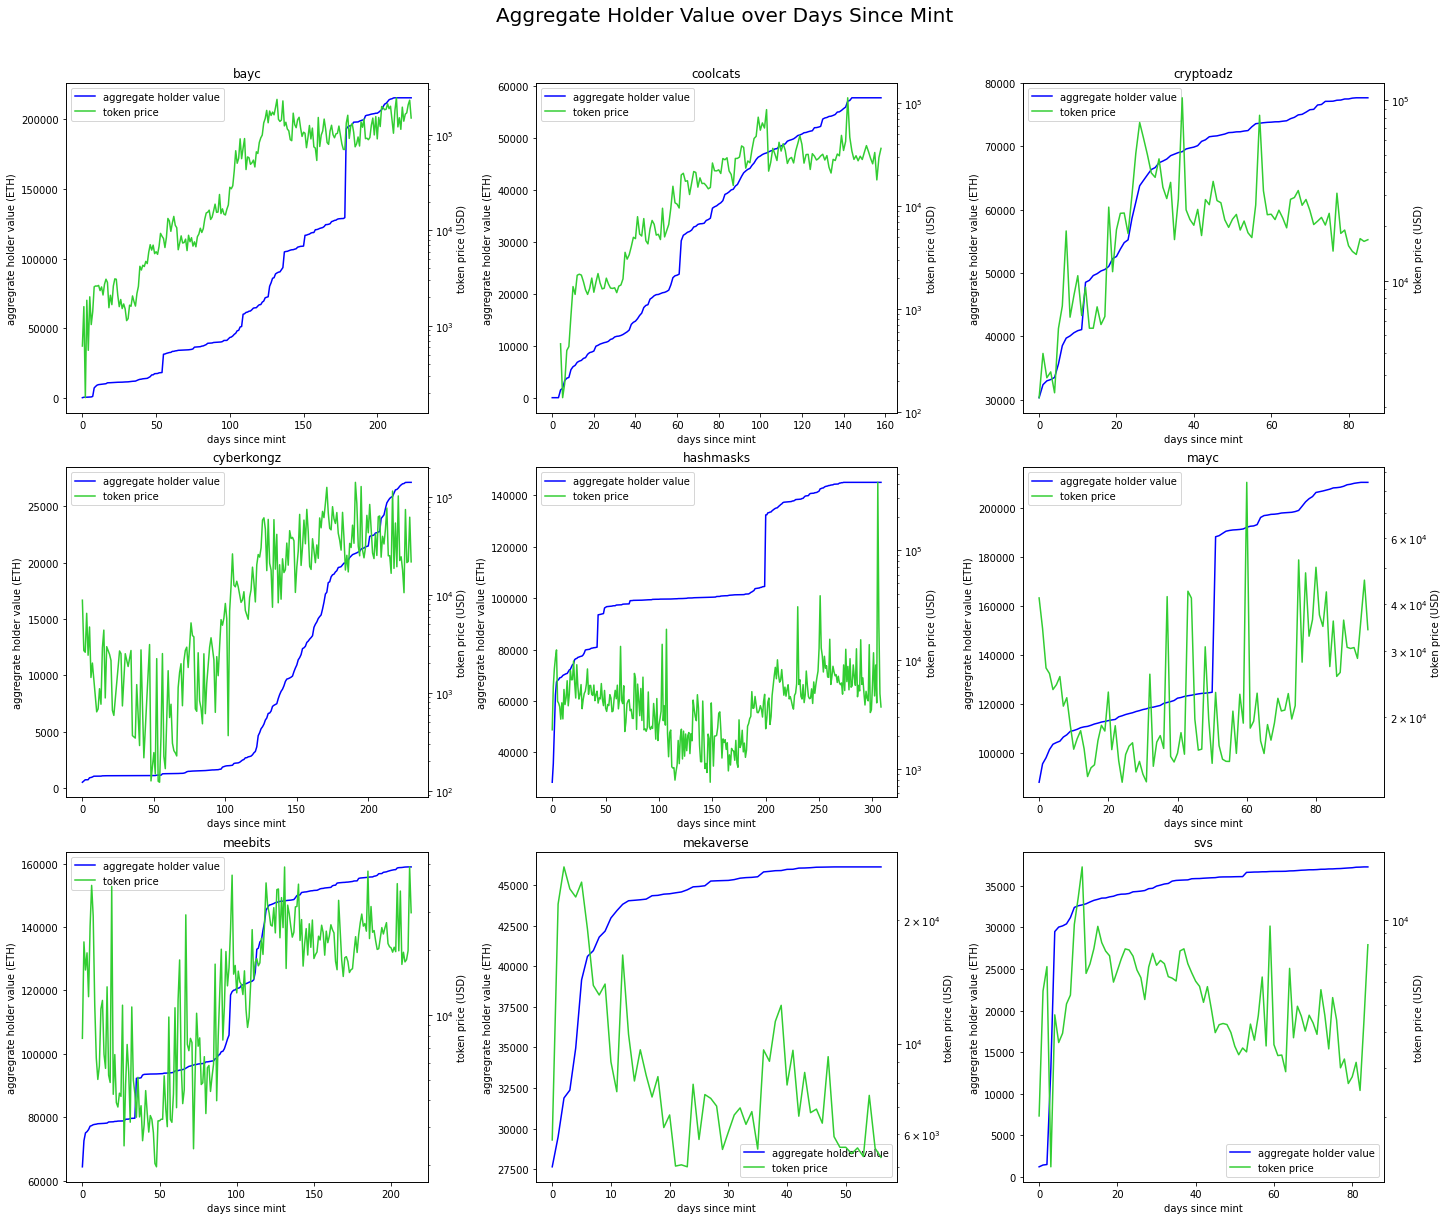

In [797]:
plot_aggregate_holder_value_over_dsm(df_summaries)

# Network Measures

### Load data

In [798]:
df_snapshots = {}

column_names = [
    "time_bucket", 
    "time_bucket_label",
    "number_of_nodes", 
    "reciprocity", 
    "assortativity", 
    "assortativity_base", 
    "assortativity_out_out", 
    "assortativity_in_in", 
    "assortativity_in_out",
    "centrality_degree",
    "centrality_closeness"
]

# dropping columns will be removed after the cleanup script is run

for project in projects:
    np_data = np.load(f"./memory/{project}/snapshots/summary.npy", allow_pickle=True)
    df = pd.DataFrame(data=np_data, columns=column_names).infer_objects()
    
    initial_date = df.head(1)['time_bucket_label'][0].date()
    
    for i, row in df.iterrows():
        days_since_mint = (row['time_bucket_label'].date() - initial_date).days
        df.loc[i, 'days_since_mint'] = days_since_mint
    
    df_snapshots[project] = df

### Helper to plot snapshot characteristics

In [799]:
attribute_names = {
    "reciprocity": "Reciprocity",
    "assortativity": "Assortativity", 
    "assortativity_base": "Undirected Assortativity", 
    "assortativity_out_out": "Out-Out Assortativity", 
    "assortativity_in_in": "In-In Assortativity", 
    "assortativity_in_out": "In-Out Assortativity",
    "centrality_degree": "Degree Centrality",
    "centrality_closeness": "Closeness Centrality", 
}

colors = ['b', 'r', 'g', 'orange', 'purple', 'light blue', 'pink', 'fuchsia', 'gold']

In [800]:
def plot_snapshot_attribute_over_time_bucket(dfs, attribute):
    fig, axs = plt.subplots(1, figsize=(12, 8), constrained_layout=True)
    fig.suptitle(f'Network {attribute_names[attribute]} over Normalized Time Buckets', y=1.05, fontsize=20)
    
    for key in dfs.keys():
        df = dfs[key]
        y = df[attribute]
    
        if attribute in ['centrality_degree', 'centrality_closeness']:
            y_series = []
            for entry in y:
                temp = []
                for x in entry.values():
                    temp.append(x)
                y_series.append(sum(temp)/len(temp))
                
            y = y_series
        
        plt.plot(df.time_bucket, y, label=key)
        plt.legend()

### Assortativity

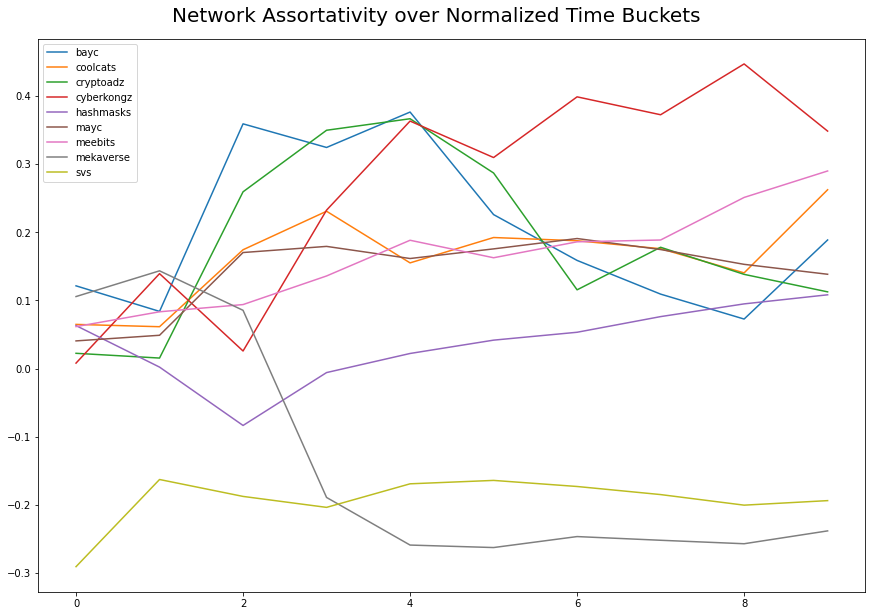

In [801]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "assortativity")

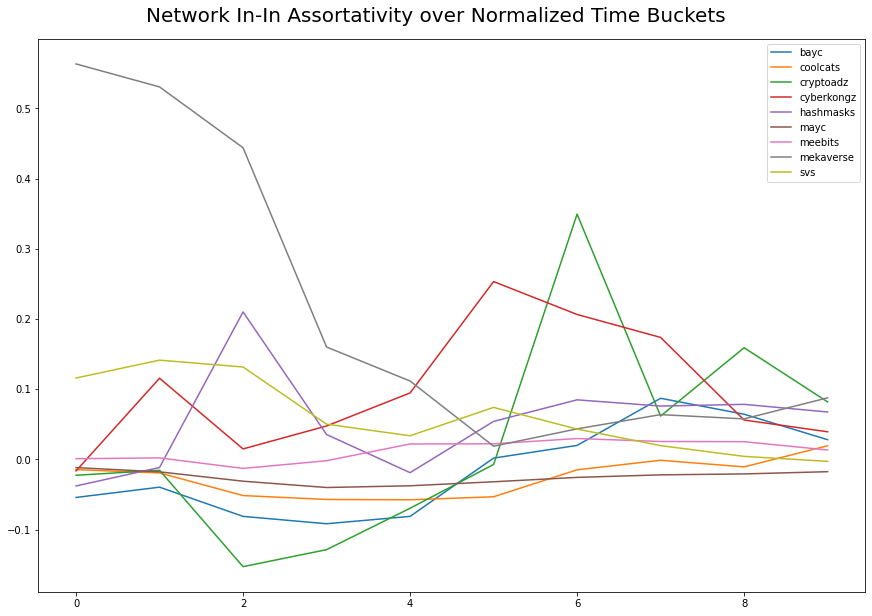

In [802]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "assortativity_in_in")

### Centrality

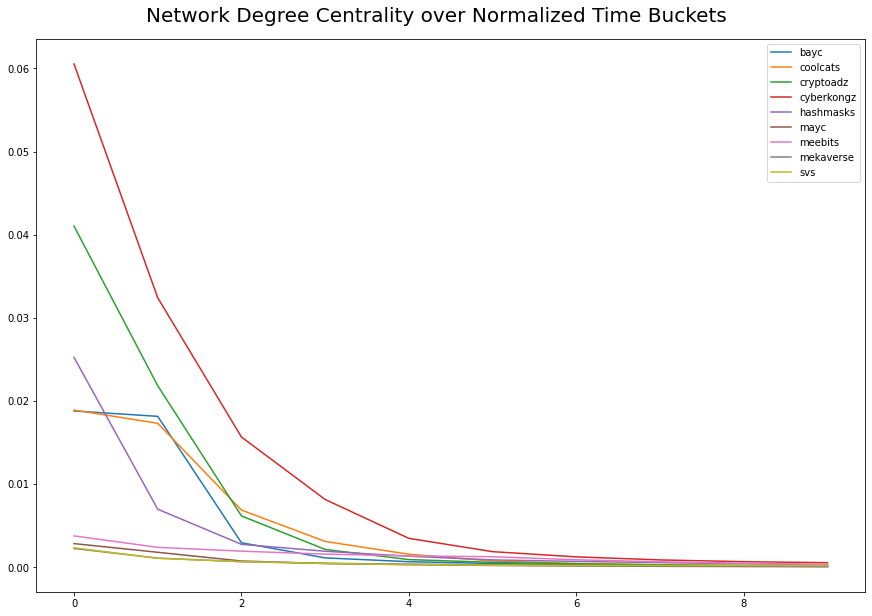

In [803]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "centrality_degree")

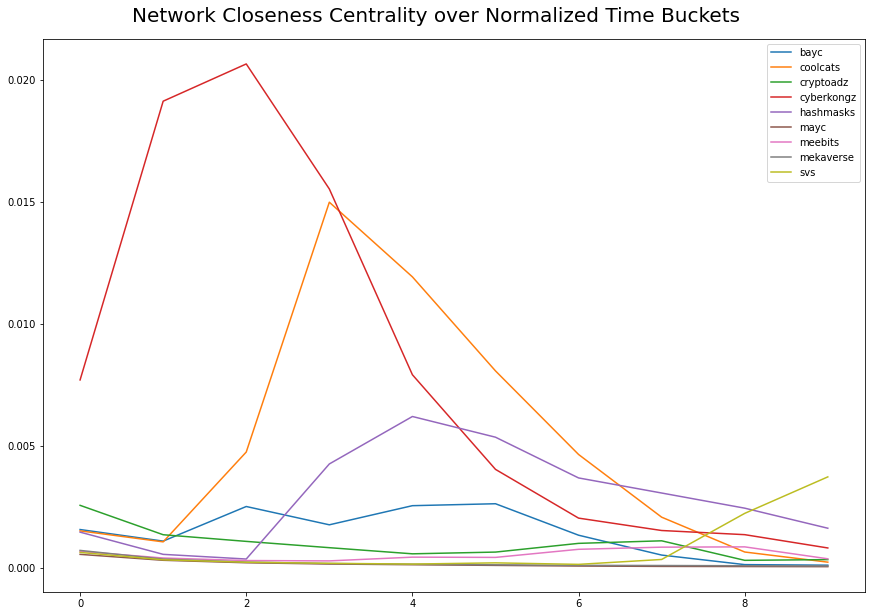

In [804]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "centrality_closeness")

### Reciprocity

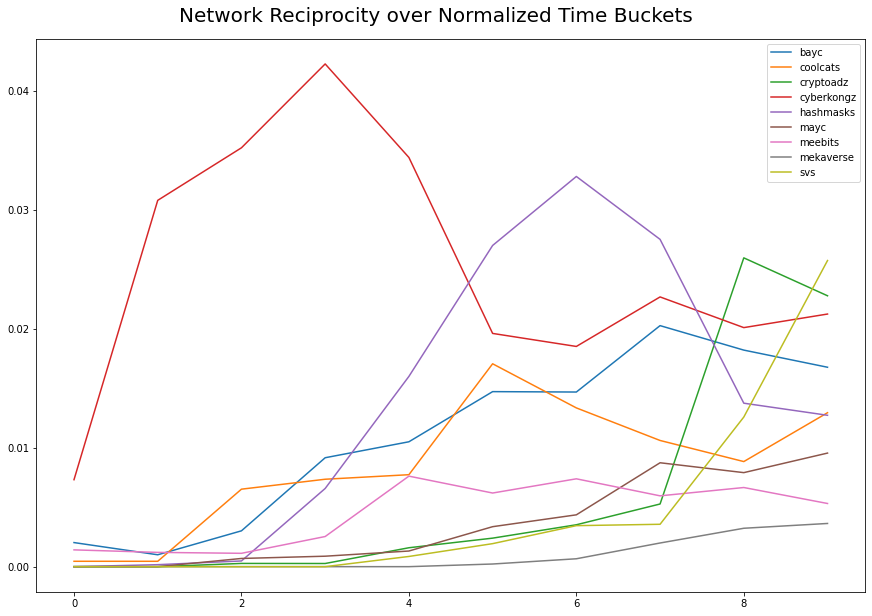

In [805]:
plot_snapshot_attribute_over_time_bucket(df_snapshots, "reciprocity")

### Power law analysis

In [806]:
def pure(x, alpha):
    return x**(-alpha)

def poisson(k, avg_degree):
    return (np.exp(-1 * avg_degree) * np.power(avg_degree, k)) / factorial(k)

def exp(k, avg_degree):
    return ((1/avg_degree) * np.exp((k * (-1)) / avg_degree))

def round_float(x):
    if x in [float("-inf"),float("inf")]: return float(0)
    return x

In [808]:
def plot_graph_power_law(g, project):
    """This function doesn't work at the moment"""
    k = np.asarray([d for d in dict(g.degree()).values()])
    avg_degree = sum(k) / len(g.nodes())

    spacing = np.linspace(min(k),max(k),len(k))
    
    fit = powerlaw.Fit(k)
    
    alpha = fit.power_law.alpha
    sigma = fit.power_law.sigma
    
    # This guy is causing problems unfortunately 
    # fit.power_law.plot_pdf(color='b', linestyle='--', label="Fit PDF")
    
    plt.plot(spacing, pure(spacing, alpha), color='r', label='Pure alpha Fit')
    plt.plot(spacing, poisson(spacing, avg_degree), color='g', label="Poisson Dist.")
    plt.plot(spacing, exp(spacing, avg_degree), color='orange', label="Exponential Dist.")
    
    plt.legend()
    plt.title(project)
    
    plt.xlabel("k")
    plt.ylabel("p(k)")

    plt.annotate("alpha: {:.2f}\nsigma: {:.2f}".format(alpha, sigma), xy=(0.80, 0.85), xycoords='axes fraction')
    
    plt.ylim(0.000000001, 1)